## Методические указания по выполнению лабораторной работы №3

**Тема: Обнаружение объектов с использованием Faster R-CNN**

**Цель работы:** Ознакомиться с архитектурой Faster R-CNN и принципами двухэтапного обнаружения объектов.

**Задачи:**
- Изучить теоретические основы двухэтапного обнаружения объектов: роль RPN и классификационного этапа в Faster R-CNN.
- Загрузить предобученную модель Faster R-CNN.
- Ознакомиться с форматом аннотаций для обучения в задаче детекции.
- Визуализировать предсказания, проанализировать ошибки модели и провести исследование по поиску баланса FN/FP.

### 1. Теоретическая часть

В данной лабораторной работе мы познакомимся с задачей детекции на примере архитектуры [Faster R-CNN](https://arxiv.org/pdf/1506.01497), обученной на наборе данных [COCO](https://cocodataset.org/#home), а также с новым форматом данных для обучения нейро-сетевых моделей детекции. Для оценки модели воспользуемся набором данных [Pascal VOC 2007](http://host.robots.ox.ac.uk/pascal/VOC/).

**Перед тем, как приступать к выполнению практической части, ознакомьтесь с первоисточниками используемых компонентов, а также документацией по [ссылке](https://pytorch.org/vision/master/models/faster_rcnn.html), включающей подробности работы с моделью и новым форматом данных, сэмплы кода.**

#### 1.1 Архитектура Faster R-CNN

Существует два основных подхода к обнаружению объектов:
Двухстадийные модели – более точные, но медленные.
Одностадийные модели – быстрые, но менее точные.

Faster R-CNN — это двухэтапная модель детекции объектов. В отличие от ResNeXt, Faster R-CNN не просто классифицирует изображение, а находит на нём несколько объектов, предсказывает bounding boxes и присваивает метки классам. Она состоит из следующих компонентов:

1. Backbone (ResNet/VGG/MobileNet) – извлекает признаки из изображения.
2. Region Proposal Network (RPN) – предлагает области, где могут находиться объекты.
3. ROI Pooling + Fully Connected Layers – классифицирует объекты и уточняет bounding boxes.
4. Non-Maximum Suppression (NMS) – убирает дублирующиеся предсказания.


В предыдущих лабораторных работах мы познакомились с классификацией изображений, где модель предсказывает единственный класс для всего изображения. Однако во многих задачах компьютерного зрения классификация недостаточна. Например, когда на одном изображении присутствуют несколько объектов разных классов необходимо не только определить, что изображено, но и где это находится.

Faster R-CNN –  модель, которая также решает задачу обнаружения объектов, добавляя к классификации локализацию. 

#### 1.2 Формат данных для задачи детекции

Faster R-CNN требует разметки изображений, помимо классов включающей в себя и координаты bounding box по оси x, y.
Ознакомьтесь с форматом набора данных Pascal VOC, скачайте аннотации набора данных и изучите структуру **.xml** файлов в папке Annotations по [ссылке](http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtestnoimgs_06-Nov-2007.tar).

#### 1.3 Оценка качества

Помимо известных вам инструментов оценить качество работы детектора могут помочь:

Confidence Score - значение, указывающее на уверенность модели в том, что на данном месте изображения находится объект. Модель предсказывает этот параметр для каждого предсказанного bounding box. Чем выше confidence score, тем более уверена модель в своём предсказании.

Фильтрация предсказаний - модель может предсказать много объектов, но не все из них будут точными. Чтобы уменьшить количество ложных срабатываний (False Positives), применяется фильтр предсказаний, используя confidence threshold. Если confidence score меньше заданного порога - предсказание отбрасывается.


### 2. Практическая часть

#### 2.1 Подготовка окружения

Установите зависимости и библиотеки:

In [21]:
# импорт пакетов
import os
import numpy as np
import torch
from torchvision.transforms import functional as F
from torchvision.datasets import VOCDetection
from matplotlib import pyplot as plt
from PIL import ImageOps
import torchvision

#### 2.2 Подготовка модели

Загрузите предобученную модель, определите устройство, переведите модель в режим инференса:

In [22]:

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# импорт модели
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
model.to(device)
model.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

#### 2.3 Загрузка и предобработка изображений


Затем импортируйте датасет из соответствующих пакетов PyTorch и определите метод трансформации данных для подачи в модель. Он понадобится позже для преобразования изображений при прямом проходе через модель чтобы получить предсказания:

In [23]:
# загрузка датасета
# Определение пути к Pascal VOC
data_path = "./"

# Загрузка датасета Pascal VOC
voc_dataset = VOCDetection(
    root=data_path,
    year="2007",
    image_set="train",
    download=False
)

# метод трансформации
def transform_image(image):
    # return F.normalize(F.to_tensor(image), mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    return F.to_tensor(image)



#### 2.4 Объявление методов для работы с данными

Далее необходимо создать методы препроцессинга: метод чтения файла аннотации для возврата numpy-объекта содержащего bounding boxes, и метод отрисовки истиных и прогнозных bounding boxes на изображении для визуализации полученных результатов.

In [24]:
from PIL import Image, ImageDraw
import xml.etree.ElementTree as ET

def parse_voc_annotation(xml_path):
    tree = ET.parse(xml_path)
    root = tree.getroot()
    boxes = []

    for obj in root.findall("object"):
        bbox = obj.find("bndbox")
        xmin, ymin, xmax, ymax = (int(bbox.find("xmin").text), int(bbox.find("ymin").text),
                                  int(bbox.find("xmax").text), int(bbox.find("ymax").text))
        boxes.append([xmin, ymin, xmax, ymax])
    return np.array(boxes)

def draw_predictions(image, boxes, labels, scores, color="blue"):
    draw = ImageDraw.Draw(image)
    for box, label, score in zip(boxes, labels, scores):
        xmin, ymin, xmax, ymax = map(int, box)
        draw.rectangle([xmin, ymin, xmax, ymax], outline=color, width=2)
        draw.text((xmin, ymin), f"{label} ({score:.2f})", fill=color)
    return image

def draw_true_predictions(image, boxes, color="blue"):
    draw = ImageDraw.Draw(image)
    for box in boxes:
        xmin, ymin, xmax, ymax = map(int, box)
        draw.rectangle([xmin, ymin, xmax, ymax], outline=color, width=2)
    return image

#### 2.5 Анализ False Positives / False Negatives

Для измерения того, насколько хорошо bounding box предсказан, применяется параметр IoU (Intersection over Union) между двумя bounding boxes. Чем он выше, тем точнее предсказание. Для его оценки опишем следующий метод, принимающий два np.array-объекта (прогнозные и истинные координаты):

In [25]:
def calculate_iou(pred_box, gt_box):
    x1, y1, x2, y2 = pred_box
    x1g, y1g, x2g, y2g = gt_box
    
    xi1 = max(x1, x1g)
    yi1 = max(y1, y1g)
    xi2 = min(x2, x2g)
    yi2 = min(y2, y2g)

    inter_area = max(0, xi2 - xi1) * max(0, yi2 - yi1)
    box1_area = (x2 - x1) * (y2 - y1)
    box2_area = (x2g - x1g) * (y2g - y1g)

    union_area = box1_area + box2_area - inter_area
    return inter_area / union_area if union_area > 0 else 0

#### 2.6 Оценка модели и визуализация результатов

Выполните прямой проход нескольких изображений через модель. Для этого необходимо загрузить изображения и аннотации, применить преобразование изображений в тензор. Затем получите выходы модели:

Средний IoU для изображения 000012.jpg: 0.9041
Для изображения 000012.jpg: True positive=1, False positive=0, False negative=0


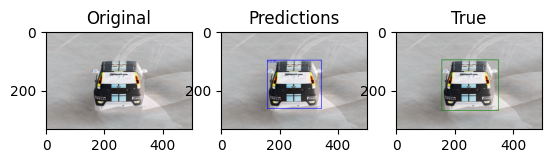

Средний IoU для изображения 000017.jpg: 0.1716
Для изображения 000017.jpg: True positive=2, False positive=6, False negative=0


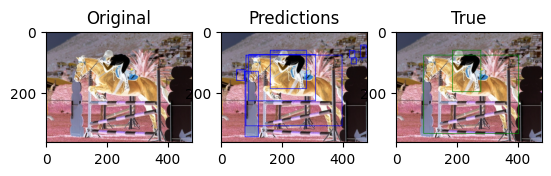

Средний IoU для изображения 000023.jpg: 0.2070
Для изображения 000023.jpg: True positive=3, False positive=1, False negative=3


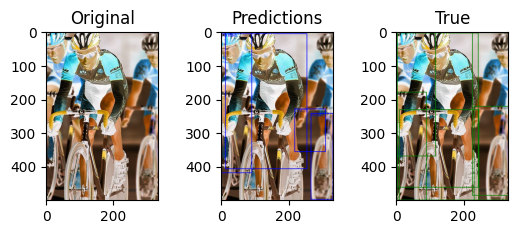

Средний IoU для изображения 000026.jpg: 0.9166
Для изображения 000026.jpg: True positive=1, False positive=0, False negative=0


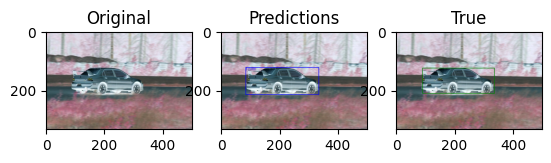

Средний IoU для изображения 000032.jpg: 0.1271
Для изображения 000032.jpg: True positive=3, False positive=1, False negative=1


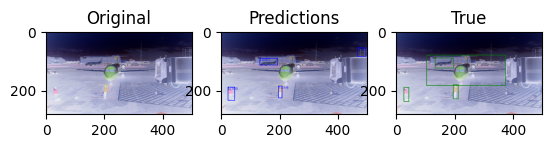

In [26]:

# выберите N изображений из датасета
N = 5
image_filenames = [voc_dataset[i][1]['annotation']['filename'] for i in range(N)]


# объявите цикл для проверки
for img_path in image_filenames:
    # загрузите изображение и его разметку
    img_full_path = os.path.join(data_path, "VOCdevkit", "VOC2007", "JPEGImages", img_path)
    xml_full_path = os.path.join(data_path, "VOCdevkit", "VOC2007", "Annotations", img_path.replace(".jpg", ".xml"))

    image = Image.open(img_full_path).convert("RGB")

    b, g, r = image.split()
    image = Image.merge("RGB", (r, g, b))
    image = ImageOps.invert(image)

    gt_boxes = parse_voc_annotation(xml_full_path)
    # примените трансформации
    input_tensor = transform_image(image).unsqueeze(0).to(device)
    # выполните прямой проход
    with torch.no_grad():
        outputs = model(input_tensor)

    # извлекаем bounding boxes, метки и confidence scores из полученных выходов модели
    pred_boxes = outputs[0]['boxes'].cpu().numpy()
    pred_labels = outputs[0]['labels'].cpu().numpy()
    pred_scores = outputs[0]['scores'].cpu().numpy()

    # установите порог confidence_threshold в эмпирическом значении
    confidence_threshold = 0.5

    # примените фильтр выходных значений на основе заданного порога
    mask = pred_scores >= confidence_threshold
    pred_boxes = pred_boxes[mask]
    pred_labels = pred_labels[mask]
    pred_scores = pred_scores[mask]

    # отрисуйте bounding boxes на изображении с предсказаниями
    image_with_predictions = draw_predictions(image.copy(), pred_boxes, pred_labels, pred_scores, color="blue")

    # отрисуйте bounding boxes с реальной разметкой
    image_with_ground_truths = draw_true_predictions(image.copy(), gt_boxes, color="green")

    # вычислите IoU для выбранных изображений
    iou_scores = []
    for pred_box in pred_boxes:
        for gt_box in gt_boxes:
            iou_scores.append(calculate_iou(pred_box, gt_box))
    print(f"Средний IoU для изображения {img_path}: {np.mean(iou_scores):.4f}")

    # подсчитайте количество False Positive и False Negative для выбранных изображений
    # Инициализация для текущего изображения
    tp = 0
    fp = 0
    fn = 0

    # Для учета, какие ground truth боксы уже покрыты
    gt_covered = [False] * len(gt_boxes)

    # Сравнение предсказаний с ground truth
    for pred_box in pred_boxes:
        matched = False
        for i, gt_box in enumerate(gt_boxes):
            iou = calculate_iou(pred_box, gt_box)
            if iou >= confidence_threshold:  # Если IoU больше порога
                if not gt_covered[i]:  # Убедимся, что этот ground truth еще не покрыт
                    tp += 1
                    gt_covered[i] = True  # Пометим этот ground truth как покрытый
                    matched = True
                    break
        if not matched:  # Если ни один ground truth не покрыт этим предсказанием
            fp += 1

    # Подсчет FN: это те ground truth, которые остались непокрытыми
    fn += sum(1 for covered in gt_covered if not covered)

    print(f"Для изображения {img_path}: True positive={tp}, False positive={fp}, False negative={fn}")
    plt.subplot(231),plt.imshow(image),plt.title('Original')
    plt.subplot(232),plt.imshow(image_with_predictions),plt.title('Predictions')
    plt.subplot(233),plt.imshow(image_with_ground_truths),plt.title('True')
    plt.show()

#### 2.7 Поиск оптимальной конфигурации 

Проанализируйте полученные результаты с выбранным значением фильтрации предсказаний. Проведите исследование с целью поиска оптимального порога и баланса FN/FP. Обоснуйте полученные результаты:

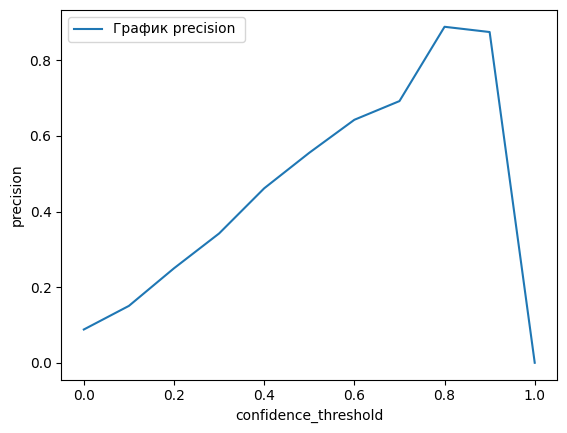

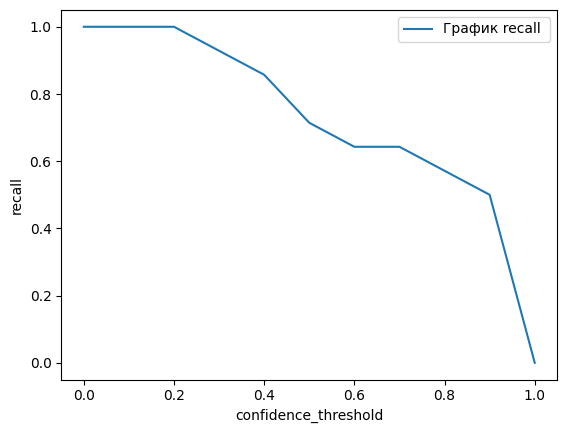

In [28]:
# исследование

# выберите N изображений из датасета
N = 5
image_filenames = [voc_dataset[i][1]['annotation']['filename'] for i in range(N)]

# confidence_thresholds = np.arange(0.3, 0.9, 0.05)  # Диапазон порогов
confidence_thresholds = [i/10 for i in range(0, 11)]
results = []

for threshold in confidence_thresholds:
    tp, fp, fn = 0, 0, 0
    predictions_amount = 0

    for img_path in image_filenames:

        img_full_path = os.path.join(data_path, "VOCdevkit", "VOC2007", "JPEGImages", img_path)
        xml_full_path = os.path.join(data_path, "VOCdevkit", "VOC2007", "Annotations", img_path.replace(".jpg", ".xml"))

        image = Image.open(img_full_path).convert("RGB")

        b, g, r = image.split()
        image = Image.merge("RGB", (r, g, b))
        image = ImageOps.invert(image)

        gt_boxes = parse_voc_annotation(xml_full_path)
        # трансформации
        input_tensor = transform_image(image).unsqueeze(0).to(device)

        # Прямой проход через модель
        with torch.no_grad():
            outputs = model(input_tensor)

        pred_boxes = outputs[0]["boxes"].cpu().numpy()
        pred_scores = outputs[0]["scores"].cpu().numpy()

        mask = pred_scores >= threshold
        pred_boxes = pred_boxes[mask]

        # Подсчет TP/FP/FN на основе IoU > 0.5
        for gt_box in gt_boxes:
            if any(calculate_iou(pred_box, gt_box) > 0.5 for pred_box in pred_boxes):
                tp += 1
            else:
                fn += 1

        predictions_amount += len(pred_boxes)

    fp = predictions_amount - tp
    results.append((threshold, tp, fp, fn))

precisions = []
recalls = []
# Анализ результатов
for threshold, tp, fp, fn in results:
    precision = tp / (tp + fp) if tp + fp > 0 else 0
    recall = tp / (tp + fn) if tp + fn > 0 else 0
    precisions.append(precision)
    recalls.append(recall)
    # print(f"Threshold: {threshold:.2f}, Precision: {precision:.4f}, Recall: {recall:.4f}")


# График precisions
plt.plot(confidence_thresholds, precisions, label='График precision ')
plt.xlabel('confidence_threshold')
plt.ylabel('precision')
plt.legend()
plt.show()

# График recalls
plt.plot(confidence_thresholds, recalls, label='График recall ')
plt.xlabel('confidence_threshold')
plt.ylabel('recall')
plt.legend()
plt.show()


### Вывод:
## CT = 0.2 подойдёт если нужно гарантированно распознать все объекты на изображении.
## CT = 0.9 подойдёт, если нужно получить меньше False Positive результатов
## CT = 0.7 подойдёт, если нужно соблюсти баланс между нахождением всех объектов и малым количеством False Positive